In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Inputs:
[[ 0.97143516 -0.69097569]
 [ 1.93270697  0.1873481 ]
 [-0.22058873  1.38716294]
 ...
 [-0.78115254  0.21151299]
 [ 0.18774457 -0.34932922]
 [ 0.30066834  0.0296339 ]]
Targets:
[1. 1. 1. ... 0. 0. 0.]


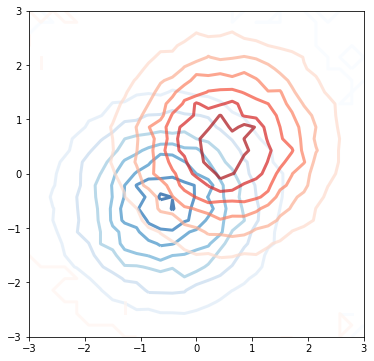

In [2]:
num_samples = 100000

mean_sig = np.array([0.5, 0.5])
cov_sig = np.array([[1.0, 0.0],
                    [0.0, 1.0]])
x_sig = np.random.multivariate_normal(mean_sig, cov_sig, num_samples)
y_sig = np.ones(num_samples)

mean_bkg = np.array([-0.5, -0.5])
cov_bkg = np.array([[1.0, 0.0],
                    [0.0, 1.0]])
x_bkg = np.random.multivariate_normal(mean_bkg, cov_bkg, num_samples)
y_bkg = np.zeros(num_samples)

x = np.vstack([x_sig, x_bkg])
y = np.hstack([y_sig, y_bkg])

print("Inputs:\n{}".format(x))
print("Targets:\n{}".format(y))

plt.figure(figsize=(6,6))
bins = np.linspace(-3, 3, 30)
counts, _, _, _ = plt.hist2d(x[:, 0][y == 0], x[:, 1][y == 0], bins=(bins, bins), alpha=0.0)
plt.contour(counts, extent=(-3, 3, -3, 3), linewidths=3, cmap=plt.cm.Blues, alpha=0.7);
counts, _, _, _ = plt.hist2d(x[:, 0][y == 1], x[:, 1][y == 1], bins=(bins, bins), alpha=0.0)
plt.contour(counts, extent=(-3, 3, -3, 3), linewidths=3, cmap=plt.cm.Reds, alpha=0.7);

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=1234)

In [4]:
model = Sequential()
model.add(Dense(100, activation="tanh", input_shape=(x.shape[1], )))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [5]:
history = model.fit(x_train, y_train,
                    batch_size = x_train.shape[0] // 10,
                    epochs = 10000,
                    callbacks=[EarlyStopping(patience=2, verbose=1)],
                    validation_split=0.75
                   )

Train on 25000 samples, validate on 75000 samples
Epoch 1/10000
25000/25000 [==============================] - 0s 10us/step - loss: 0.6839 - val_loss: 0.6663
Epoch 2/10000
25000/25000 [==============================] - 0s 3us/step - loss: 0.6562 - val_loss: 0.6401
Epoch 3/10000
25000/25000 [==============================] - 0s 3us/step - loss: 0.6309 - val_loss: 0.6167
Epoch 4/10000
25000/25000 [==============================] - 0s 4us/step - loss: 0.6080 - val_loss: 0.5958
Epoch 5/10000
25000/25000 [==============================] - 0s 4us/step - loss: 0.5876 - val_loss: 0.5777
Epoch 6/10000
25000/25000 [==============================] - 0s 3us/step - loss: 0.5702 - val_loss: 0.5623
Epoch 7/10000
25000/25000 [==============================] - 0s 3us/step - loss: 0.5554 - val_loss: 0.5492
Epoch 8/10000
25000/25000 [==============================] - 0s 3us/step - loss: 0.5428 - val_loss: 0.5381
Epoch 9/10000
25000/25000 [==============================] - 0s 3us/step - loss: 0.5322 - val

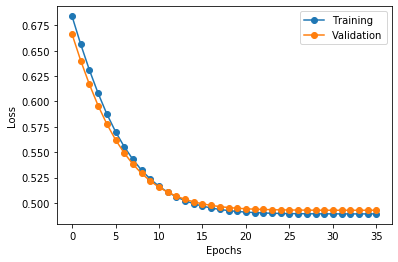

In [6]:
plt.plot(range(len(history.history["loss"])), history.history["loss"], "o-", label="Training")
plt.plot(range(len(history.history["val_loss"])), history.history["val_loss"], "o-", label="Validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss");

In [7]:
weights = {}
for layer in model.layers:
    print("Layer: {}".format(layer.name))
    for weight, array in zip(layer.weights, layer.get_weights()):
        print("    weight, shape: {}, {}".format(weight.name, np.array(array).shape))
        weights[weight.name] = np.array(array)

Layer: dense_1
    weight, shape: dense_1/kernel:0, (2, 100)
    weight, shape: dense_1/bias:0, (100,)
Layer: dense_2
    weight, shape: dense_2/kernel:0, (100, 1)
    weight, shape: dense_2/bias:0, (1,)


In [8]:
x_ph = tf.placeholder(tf.float32)
w1 = tf.get_variable('w1', initializer=weights['dense_1/kernel:0'])
b1 = tf.get_variable('b1', initializer=weights['dense_1/bias:0'])
w2 = tf.get_variable('w2', initializer=weights['dense_2/kernel:0'])
b2 = tf.get_variable('b2', initializer=weights['dense_2/bias:0'])

l1 = tf.tanh(tf.add(b1, tf.matmul(x_ph, w1)))
f = tf.sigmoid(tf.add(b2, tf.matmul(l1, w2)))

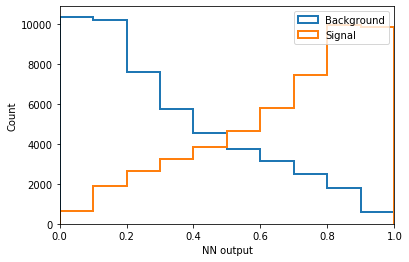

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
y_pred = sess.run(f, {x_ph: x_test})

bins = np.linspace(0, 1, 11)
plt.hist(y_pred[y_test == 0], bins=bins, histtype="step", lw=2, label="Background")
plt.hist(y_pred[y_test == 1], bins=bins, histtype="step", lw=2, label="Signal")
plt.legend()
plt.xlim((0, 1))
plt.xlabel("NN output")
plt.ylabel("Count");

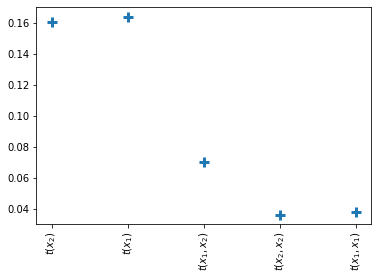

In [10]:
f_dx = tf.gradients(f, x_ph)[0]
f_dx1dx = tf.gradients(f_dx[:, 0], x_ph)[0]
f_dx2dx = tf.gradients(f_dx[:, 1], x_ph)[0]

f_dx_, f_dx1dx_, f_dx2dx_ = sess.run([f_dx, f_dx1dx, f_dx2dx], {x_ph: x_test})

f_dx1 = np.mean(np.abs(f_dx_[:, 0]))
f_dx2 = np.mean(np.abs(f_dx_[:, 1]))
f_dx1dx1 = np.mean(np.abs(0.5 * f_dx1dx_[:, 0]))
f_dx1dx2 = np.mean(np.abs(0.5 * 2.0 * f_dx1dx_[:, 1]))
f_dx2dx2 = np.mean(np.abs(0.5 * f_dx2dx_[:, 1]))

plt.plot(range(5), [f_dx2, f_dx1, f_dx1dx2, f_dx2dx2, f_dx1dx1], "+", mew=3, ms=10)
plt.xticks(range(5), ["$t(x_2)$", "$t(x_1)$", "$t(x_1, x_2)$", "$t(x_2, x_2)$", "$t(x_1, x_1)$"], rotation=90);